
Make sure to that your system has cuda enabled GPU to for faster XGBoost training. See [XgBoost GPU Support](https://xgboost.readthedocs.io/en/latest/gpu/index.html)

### get data

In [ ]:
import pandas as pd

Link to the dataset: 
https://drive.google.com/file/d/1Nl-RU5HggCSWWqINN4gbxHAVzER6T2Po/view?usp=sharing

In [ ]:
data = pd.read_csv('/content/HIGGS_6M.csv.gz', compression='gzip', header=None)

In [ ]:
data.shape

(6000000, 29)

In [ ]:
data.isna().sum().sum()

0

In [ ]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,1.374992,-0.653674,0.930349,1.107436,1.138904,-1.578198,-1.046985,0.000000,0.657930,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,-0.213642,1.271015,2.214872,0.499994,-1.261432,0.732156,0.000000,0.398701,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,1.540659,-0.819690,2.214872,0.993490,0.356080,-0.208778,2.548224,1.256955,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,-0.676016,0.736159,2.214872,1.298720,-1.430738,-0.364658,0.000000,0.745313,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,1.020974,0.971407,2.214872,0.596761,-0.350273,0.631194,0.000000,0.479999,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487


In [ ]:
data[0].value_counts()

1.0    3178345
0.0    2821655
Name: 0, dtype: int64

In [ ]:
data.dtypes.unique()

array([dtype('float64')], dtype=object)

### Setup

In [ ]:
seed = 123

import xgboost as xgb
from xgboost import DMatrix
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def show_score(y_true, y_pred_proba, name='', cm=False, roc=True):
  y_pred = y_pred_proba.round()
  print('_'*40 + name+' data' + '_'*40)
  # print('Accuracy: ', accuracy_score(y_true, y_pred), end='\n'*2)
  print('Classification Report:')
  print(classification_report(y_true, y_pred), end='\n')
  print('-'*80)
  print('ROC AUC Score:')
  print(roc_auc_score(y_true, y_pred_proba))
  print('-'*80)
  
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
  if cm:
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'], ax=ax1);
    ax1.set_title('Confusion Matrix')

  if roc:
    fpr, tpr, th = roc_curve(y_true, y_pred_proba)  
    ax2.set_title('ROC Curve')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_xlabel('False Positive Rate')
    ax2.plot(fpr, tpr, linestyle='--');
  plt.show()
  print('-'*80)

### prepare input data

In [ ]:
test_size = 500000
train_size = data.shape[0] - test_size

# train set
X_train = data.iloc[: train_size, 1:]
y_train = data.iloc[: train_size, 0]

# test set
X_test = data.iloc[-test_size:, 1:]
y_test = data.iloc[-test_size:, 0]

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5500000, 28), (5500000,), (500000, 28), (500000,))

In [ ]:
dtrain = DMatrix(data=X_train, label=y_train)
dtest = DMatrix(data=X_test, label=y_test)

### Train (XGBoost)

In [ ]:
params = {'objective': 'binary:logistic', 'eval_metric': 'auc', 'seed': seed, 
          'max_depth': 8, 'eta': 0.3, 'tree_method': 'gpu_hist', 'gpu_id': 0}

In [ ]:
clf = xgb.train(params=params, dtrain=dtrain, num_boost_round=350)  

In [ ]:
y_pred_train_proba = clf.predict(dtrain)
y_pred_test_proba = clf.predict(dtest)

### Results

________________________________________Train data________________________________________
Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.75      0.76   2586725
         1.0       0.79      0.81      0.80   2913275

    accuracy                           0.78   5500000
   macro avg       0.78      0.78      0.78   5500000
weighted avg       0.78      0.78      0.78   5500000

--------------------------------------------------------------------------------
ROC AUC Score:
0.866308523866095
--------------------------------------------------------------------------------


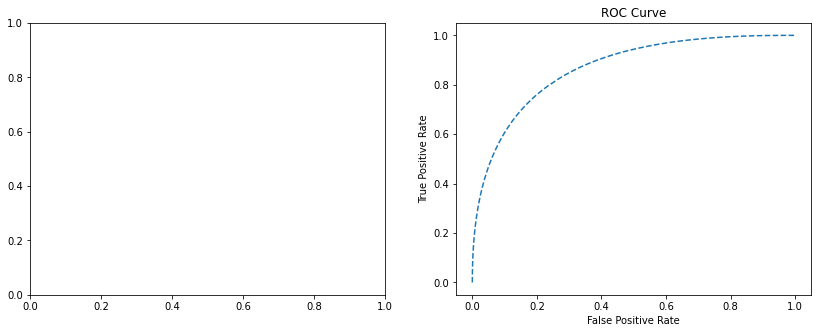

--------------------------------------------------------------------------------


In [ ]:
show_score(y_train, y_pred_train_proba, name='Train', cm=False)

##### Performance on untouched test set (last 500K samples)

________________________________________Test data________________________________________
Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.73      0.74    234930
         1.0       0.77      0.78      0.78    265070

    accuracy                           0.76    500000
   macro avg       0.76      0.76      0.76    500000
weighted avg       0.76      0.76      0.76    500000

--------------------------------------------------------------------------------
ROC AUC Score:
0.8430741138771947
--------------------------------------------------------------------------------


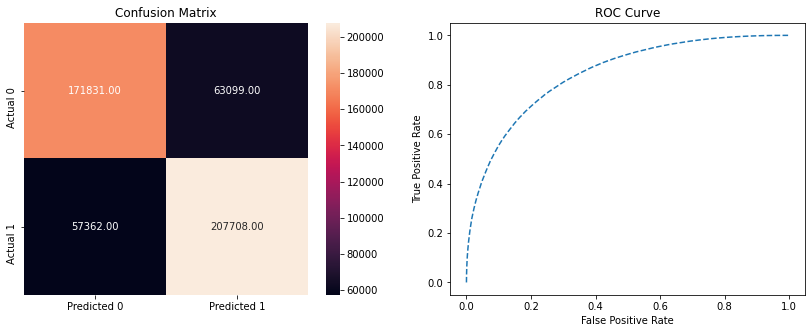

--------------------------------------------------------------------------------


In [ ]:
show_score(y_test, y_pred_test_proba, name='Test', cm=True)

### Autoencoder, reducing dimensions from 28 to 14

In [ ]:
from sklearn.preprocessing import RobustScaler 
from tensorflow.keras.layers import Dense, Input, BatchNormalization, LeakyReLU
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
# RobustScaler
scaler = RobustScaler()  
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

n_dim = X_train_scl.shape[1]
n_dim_red = 14

X_train_scl.shape, X_test_scl.shape

((5500000, 28), (500000, 28))

In [ ]:
input = Input(shape=(n_dim))

# encoder
encoder = Dense(n_dim * 2)(input)
encoder = BatchNormalization()(encoder)
encoder = LeakyReLU()(encoder)

encoder = Dense(n_dim)(encoder)
encoder = BatchNormalization()(encoder)
encoder = LeakyReLU()(encoder)

encoder = Dense(n_dim_red)(encoder)


# decoder
decoder = Dense(n_dim)(encoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)

decoder = Dense(n_dim * 2)(decoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)

decoder = Dense(n_dim)(decoder)

model = Model(inputs=input, outputs=decoder)

encoder = Model(inputs=input, outputs=encoder)

In [ ]:
# the loss is Mean Squared Error, lower the better it is
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse')

model.fit(x=X_train_scl, y=X_train_scl, 
          batch_size=128, epochs=30,
          validation_data=(X_test_scl, X_test_scl))

Epoch 1/30
42969/42969 [==============================] - 169s 4ms/step - loss: 0.1930 - val_loss: 0.1084
Epoch 2/30
42969/42969 [==============================] - 167s 4ms/step - loss: 0.1188 - val_loss: 0.0939
Epoch 3/30
42969/42969 [==============================] - 166s 4ms/step - loss: 0.1019 - val_loss: 0.0858
Epoch 4/30
42969/42969 [==============================] - 163s 4ms/step - loss: 0.0969 - val_loss: 0.0851
Epoch 5/30
42969/42969 [==============================] - 163s 4ms/step - loss: 0.0939 - val_loss: 0.0829
Epoch 6/30
42969/42969 [==============================] - 163s 4ms/step - loss: 0.0907 - val_loss: 0.0805
Epoch 7/30
42969/42969 [==============================] - 163s 4ms/step - loss: 0.0871 - val_loss: 0.0762
Epoch 8/30
42969/42969 [==============================] - 162s 4ms/step - loss: 0.0846 - val_loss: 0.0744
Epoch 9/30
42969/42969 [==============================] - 163s 4ms/step - loss: 0.0829 - val_loss: 0.0761
Epoch 10/30
42969/42969 [=====================

### prepare input data

In [ ]:
X_train_red = encoder.predict(X_train_scl, batch_size=128)
X_test_red = encoder.predict(X_test_scl, batch_size=128)

In [ ]:
X_train_red.shape, X_test_red.shape

((5500000, 14), (500000, 14))

In [ ]:
dtrain_red = DMatrix(data=X_train_red, label=y_train)
dtest_red = DMatrix(data=X_test_red, label=y_test)

### Train

In [ ]:
params = {'objective': 'binary:logistic', 'eval_metric': 'auc', 'seed': seed, 
          'max_depth': 6, 'alpha':10, 'eta': 0.3, 'tree_method': 'gpu_hist', 'gpu_id': 0}

In [ ]:
clf_red = xgb.train(params=params, dtrain=dtrain_red, num_boost_round=1000)

In [ ]:
y_pred_train_proba = clf_red.predict(dtrain_red)
y_pred_test_proba = clf_red.predict(dtest_red)

### Results

________________________________________Train data________________________________________
Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      0.61      0.65   2586725
         1.0       0.69      0.77      0.73   2913275

    accuracy                           0.70   5500000
   macro avg       0.70      0.69      0.69   5500000
weighted avg       0.70      0.70      0.69   5500000

--------------------------------------------------------------------------------
ROC AUC Score:
0.7656345023136812
--------------------------------------------------------------------------------


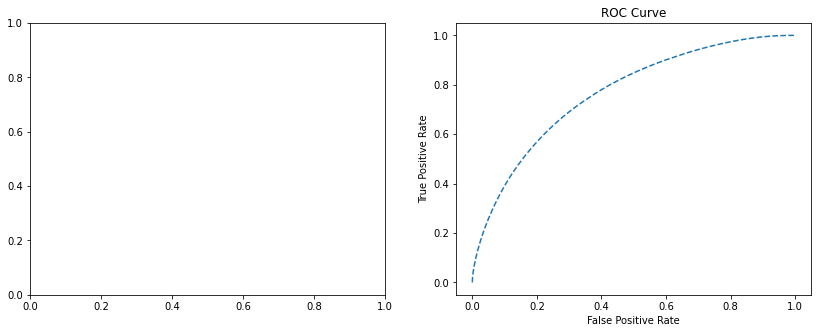

--------------------------------------------------------------------------------


In [ ]:
show_score(y_train, y_pred_train_proba, name='Train', cm=False)

##### Performance on untouched test set (last 500K samples) with low dimensional features (dimensions=14)

________________________________________Test data________________________________________
Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.59      0.63    234930
         1.0       0.67      0.75      0.71    265070

    accuracy                           0.67    500000
   macro avg       0.67      0.67      0.67    500000
weighted avg       0.67      0.67      0.67    500000

--------------------------------------------------------------------------------
ROC AUC Score:
0.736416256396276
--------------------------------------------------------------------------------


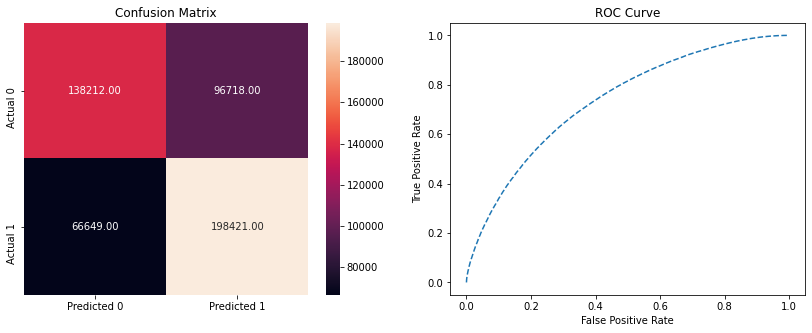

--------------------------------------------------------------------------------


In [ ]:
show_score(y_test, y_pred_test_proba, name='Test', cm=True)

- On test data, with original features (dimensions=28), ROC AUC Score = 0.8430741138771947
- On test data, with low dimensional features (dimensions=14), ROC AUC Score = 0.736416256396276

#### Pipeline:
original features -> Robust scaler -> low dimensional features -> DMatrix -> XGBoost